# Radiomic Feature Fusion for Lung Disease Classification Using Machine Learning Algorithms

In [ ]:
import os
import cv2
import mlflow
import mlflow.sklearn
import shap
import numpy as np
from tqdm import tqdm
import pywt
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # leave it
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report, roc_auc_score,
    accuracy_score, precision_score,
    recall_score, f1_score,confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def extract_hog(img):
    return hog(img, orientations=9, pixels_per_cell=(16,16),
               cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)
    
def extract_gabor_features(img, ksize=31, sigma=4.0, lambd=10.0, gamma=0.5):
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 4 orientations
    features = []

    for theta in thetas:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0)
        filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
  
        features.append(filtered.mean())
        features.append(filtered.std())
    
    return np.array(features)   # 4 orientations * 2 stats = 8 features
    
def extract_lbp_hist(img, P=8, R=1, bins=10):
    lbp = local_binary_pattern(img, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, bins+1), range=(0, bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_glcm_props(img, distances=[1,2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=64):
    img_q = (img / (img.max() / (levels - 1))).astype(np.uint8) if img.max() > levels else img.astype(np.uint8)
    glcm = graycomatrix(img_q, distances=distances, angles=angles,
                        levels=levels, symmetric=True, normed=True)
    props = [graycoprops(glcm, p).mean() for p in ['contrast','correlation','energy','homogeneity']]
    return np.array(props)

def extract_stats(img):
    arr = img.ravel().astype(np.float32)
    hist, _ = np.histogram(arr, bins=64, range=(arr.min(), arr.max()), density=True)
    entropy = -np.sum((hist + 1e-8) * np.log2(hist + 1e-8))
    return np.array([arr.mean(), arr.std(), np.percentile(arr,25),
                     np.percentile(arr,50), np.percentile(arr,75), entropy])

def extract_wavelet_glcm(img, wavelet='db2', levels=64):
    # PyWavelets: DWT level-1
    LL, (LH, HL, HH) = pywt.dwt2(img, wavelet)

    subbands = [LL, LH, HL, HH]
    feats = []

    for sb in subbands:

        sb = sb.astype(np.float32)

        m = sb.max()
        mn = sb.min()

        if m == mn:                 
            sb_q = np.zeros_like(sb, dtype=np.uint8)
        else:
            sb_norm = (sb - mn) / (m - mn)          # → 0..1
            sb_q = (sb_norm * (levels - 1)).astype(np.uint8)   # → 0..levels-1

    
        glcm = graycomatrix(
            sb_q,
            distances=[1],
            angles=[0],
            levels=levels,
            symmetric=True,
            normed=True
        )

        for prop in ['contrast','correlation','energy','homogeneity']:
            feats.append(graycoprops(glcm, prop)[0, 0])

    return np.array(feats)


def extract_features_from_image(img):
    return np.hstack([
        extract_hog(img),            
        extract_lbp_hist(img),      
        extract_glcm_props(img),    
        extract_stats(img),          
        extract_gabor_features(img), 
        extract_wavelet_glcm(img)    
    ])

hog_example = extract_hog(np.zeros((256,256), dtype=np.uint8))
hog_names = [f"hog_{i}" for i in range(len(hog_example))]

lbp_names = [f"lbp_bin_{i}" for i in range(10)]

glcm_names = ["glcm_contrast", "glcm_correlation", "glcm_energy", "glcm_homogeneity"]

stat_names = [
    "mean_intensity", "std_intensity",
    "p25_intensity", "p50_intensity", "p75_intensity",
    "entropy"
]

gabor_names = [
    "gabor_0_mean", "gabor_0_std",
    "gabor_45_mean", "gabor_45_std",
    "gabor_90_mean", "gabor_90_std",
    "gabor_135_mean", "gabor_135_std",
]

wavelet_glcm_names = [
    "wvLL_contrast", "wvLL_correlation", "wvLL_energy", "wvLL_homogeneity",
    "wvLH_contrast", "wvLH_correlation", "wvLH_energy", "wvLH_homogeneity",
    "wvHL_contrast", "wvHL_correlation", "wvHL_energy", "wvHL_homogeneity",
    "wvHH_contrast", "wvHH_correlation", "wvHH_energy", "wvHH_homogeneity",
]

feature_names = (
    hog_names +
    lbp_names +
    glcm_names +
    stat_names +
    gabor_names +
    wavelet_glcm_names
)

print("Total features:", len(feature_names))


c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total features: 8144


In [ ]:

def label_fn(filepath):
    if "NORMAL" in filepath.upper():
        return 0
    elif "BACTERIAL" in filepath.upper():
        return 1
    elif "VIRAL" in filepath.upper():
        return 2
    else:
        raise ValueError(f"Unknown label: {filepath}")

image_dir = "./chest_xray"
X_files, y = [], []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.lower().endswith(('.jpg','.png','.jpeg')):
            fp = os.path.join(root,f)
            X_files.append(fp)
            y.append(label_fn(fp))
y = np.array(y)

# Feature Engineering (Feature Extraction + Feature Selection)

## Feature Extraction

In [6]:
features = []

for fpath in tqdm(X_files, desc="Extracting Features", ncols=80):
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    img = cv2.equalizeHist(img)

    feats = extract_features_from_image(img)
    features.append(feats)

X = np.vstack(features)
print("Final Feature Matrix:", X.shape)


Extracting Features: 100%|██████████████████| 5856/5856 [04:22<00:00, 22.31it/s]


Final Feature Matrix: (5856, 8144)


## View Extracted Features

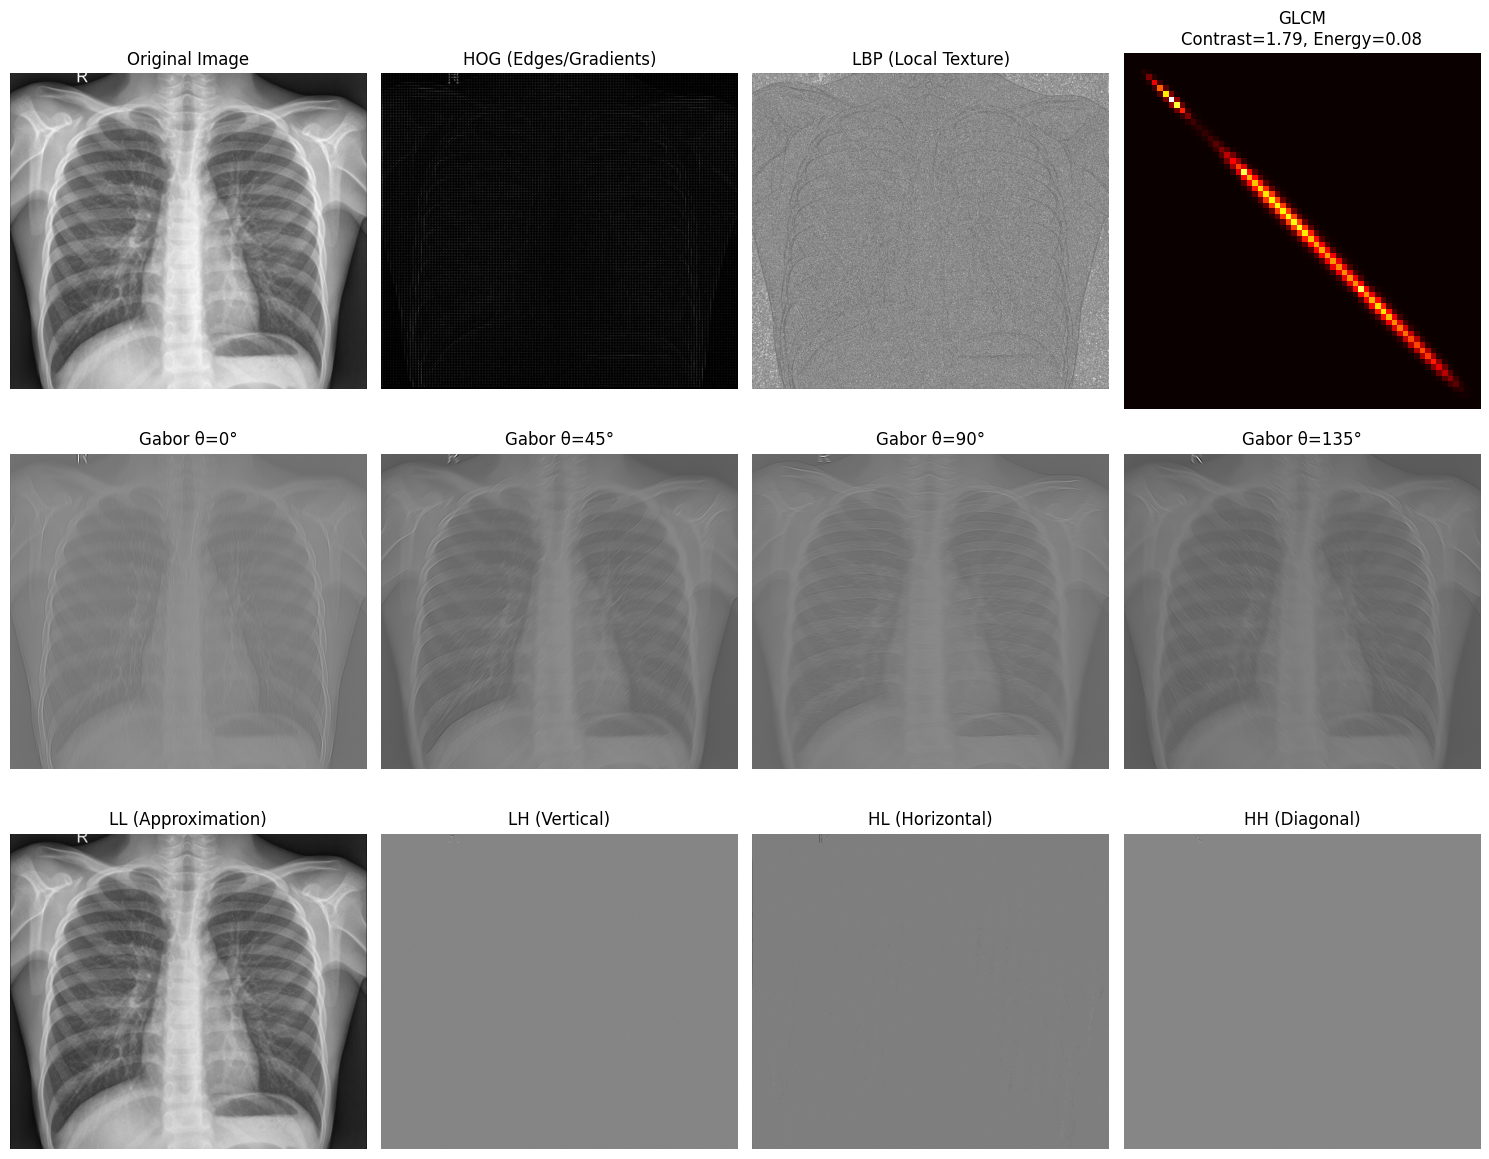

In [ ]:
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage import exposure

sample_path = "./chest_xray/NORMAL/IM-0007-0001.jpeg"
img_color = cv2.imread(sample_path)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)


hog_features, hog_image = hog(
    img_gray,
    orientations=9,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True,
    feature_vector=True
)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


P, R = 8, 1
lbp = local_binary_pattern(img_gray, P, R, method='uniform')


img_q = (img_gray / (img_gray.max() / 63)).astype(np.uint8)
glcm = graycomatrix(
    img_q,
    distances=[1],
    angles=[0],
    levels=64,
    symmetric=True,
    normed=True
)

glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
glcm_energy = graycoprops(glcm, 'energy')[0, 0]

# Extract the 2D GLCM matrix for visualization
glcm_matrix = glcm[:, :, 0, 0]


thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
gabor_images = []

for theta in thetas:
    kernel = cv2.getGaborKernel((31, 31), 4.0, theta, 10.0, 0.5, 0)
    filtered = cv2.filter2D(img_gray, cv2.CV_32F, kernel)
    gabor_images.append(filtered)


LL, (LH, HL, HH) = pywt.dwt2(img_gray, 'db2')

wavelet_images = [LL, LH, HL, HH]
wavelet_titles = ["LL (Approximation)", "LH (Vertical)", "HL (Horizontal)", "HH (Diagonal)"]

plt.figure(figsize=(15, 12))

# Row 1
plt.subplot(3, 4, 1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(3, 4, 2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG (Edges/Gradients)")
plt.axis("off")

plt.subplot(3, 4, 3)
plt.imshow(lbp, cmap="gray")
plt.title("LBP (Local Texture)")
plt.axis("off")

plt.subplot(3, 4, 4)
plt.imshow(glcm_matrix, cmap="hot")
plt.title(f"GLCM\nContrast={glcm_contrast:.2f}, Energy={glcm_energy:.2f}")
plt.axis("off")


for i, img_gabor in enumerate(gabor_images):
    plt.subplot(3, 4, 5 + i)
    plt.imshow(img_gabor, cmap='gray')
    plt.title(f"Gabor θ={i * 45}°")
    plt.axis("off")

for i, wimg in enumerate(wavelet_images):
    plt.subplot(3, 4, 9 + i)
    plt.imshow(wimg, cmap='gray')
    plt.title(wavelet_titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## Feature Selection(Features are just sorted as per importance but not selected)

In [ ]:
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd

print("\n📊 Computing feature importance: MI, Chi-Square, ANOVA BEFORE training...")

scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train)  # For MI and ANOVA
X_test_scaled  = scaler_std.transform(X_test)

scaler_min = MinMaxScaler()
X_train_nonneg = scaler_min.fit_transform(X_train)  # For Chi-Square (non-negative)

# Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# Chi-Square (requires non-negative)
chi2_scores, _ = chi2(X_train_nonneg, y_train)

# ANOVA F-test
anova_scores, _ = f_classif(X_train_scaled, y_train)

lbp_len   = 10
glcm_len  = 4
stat_len  = 6
gabor_len = 8
hog_len   = len(feature_names) - (lbp_len + glcm_len + stat_len + gabor_len)


idx_hog   = list(range(0, hog_len))
idx_lbp   = list(range(hog_len, hog_len + lbp_len))
idx_glcm  = list(range(hog_len + lbp_len, hog_len + lbp_len + glcm_len))
idx_stat  = list(range(hog_len + lbp_len + glcm_len, hog_len + lbp_len + glcm_len + stat_len))
idx_gabor = list(range(hog_len + lbp_len + glcm_len + stat_len, len(feature_names)))


top_hog_idx   = idx_hog[np.argmax(mi_scores[idx_hog])]
top_lbp_idx   = idx_lbp[np.argmax(mi_scores[idx_lbp])]
top_glcm_idx  = idx_glcm[np.argmax(mi_scores[idx_glcm])]
top_stat_idx  = idx_stat[np.argmax(mi_scores[idx_stat])]
top_gabor_idx = idx_gabor[np.argmax(mi_scores[idx_gabor])]

top_features_idx   = [top_hog_idx, top_lbp_idx, top_glcm_idx, top_stat_idx, top_gabor_idx]
top_features_names = [feature_names[i] for i in top_features_idx]

print("\n🏆 Top MI feature from each category:")
for name in top_features_names:
    print("-", name)


df_scores = pd.DataFrame({
    "Feature": feature_names,
    "MI": mi_scores,
    "Chi2": chi2_scores,
    "ANOVA_F": anova_scores
})

print("\n📄 Top 20 features sorted by MI:")
print(df_scores.sort_values("MI", ascending=False).head(20))



📊 Computing feature importance: MI, Chi-Square, ANOVA BEFORE training...

🏆 Top MI feature from each category:
- hog_4855
- gabor_90_std
- gabor_135_std
- wvLL_energy
- wvHH_homogeneity

📄 Top 20 features sorted by MI:
             Feature        MI        Chi2     ANOVA_F
8125    gabor_90_std  0.217680   61.037534  882.552539
4855        hog_4855  0.195249  139.414469  344.359200
5962        hog_5962  0.191718   72.579812  178.307298
5377        hog_5377  0.190314  141.266791  338.600324
6484        hog_6484  0.186425   68.541254  168.770341
5917        hog_5917  0.185845  131.733062  311.337323
5395        hog_5395  0.185722  136.431818  326.147025
5935        hog_5935  0.183134  115.987190  290.925626
7042        hog_7042  0.182921   78.114128  197.333454
6502        hog_6502  0.180660   81.379141  205.347676
6457        hog_6457  0.180628  112.099641  278.266005
7555        hog_7555  0.178805   97.214786  277.860961
7024        hog_7024  0.177813   78.175466  199.092507
7015      

## Top Features

In [ ]:

top_15_idx = np.argsort(mi_scores)[-15:][::-1]
top_15_names = [feature_names[i] for i in top_15_idx]

print("\n🔥 Top 15 MI features for SHAP:")
print(top_15_names)


🔥 Top 15 MI features for SHAP:
['gabor_90_std', 'hog_4855', 'hog_5962', 'hog_5377', 'hog_6484', 'hog_5917', 'hog_5395', 'hog_5935', 'hog_7042', 'hog_6502', 'hog_6457', 'hog_7555', 'hog_7024', 'hog_7015', 'hog_7537']


In [ ]:
def visualize_model_results(model_name, y_test, y_pred, y_proba, class_names):
    print(f"\n📊 Generating visualizations for {model_name}...")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(7,6))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.3f})")
    
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"{model_name} - ROC Curves (OvR)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7,6))
    for i, cls in enumerate(class_names):
        prec, rec, _ = precision_recall_curve((y_test == i).astype(int), y_proba[:, i])
        plt.plot(rec, prec, lw=2, label=f"{cls}")
    
    plt.title(f"{model_name} - Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    metrics = [acc, prec, rec, f1]
    names = ["Accuracy", "Precision", "Recall", "F1-score"]

    plt.figure(figsize=(6,4))
    sns.barplot(x=names, y=metrics, palette="viridis")
    plt.ylim(0, 1)
    plt.title(f"{model_name} - Overall Metrics")
    plt.ylabel("Score")
    plt.show()


## Model Training and Evaluation

In [ ]:

def train_and_evaluate_model(model_name, pipe, param_grid, X_train, y_train, X_test, y_test):

    print(f"\n==============================")
    print(f" Training {model_name} ")
    print(f"==============================")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = HalvingGridSearchCV(
        pipe,
        param_grid,
        cv=cv,
        scoring="roc_auc_ovr",
        n_jobs=-1,
        verbose=2
    )

    search.fit(X_train, y_train)
    best = search.best_estimator_

    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

    print("\nBest Params:", search.best_params_)
    print(classification_report(y_test, y_pred, target_names=["Normal","Bacterial","Viral"]))
    print("ROC-AUC (OvR):", auc)

    # ---- MLflow Logging ----
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(search.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc_ovr", auc)

        mlflow.sklearn.log_model(best, f"{model_name}_Model")

    visualize_model_results(model_name, y_test, y_pred, y_proba,
                        class_names=["Normal","Bacterial","Viral"])

    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "pipeline": best
    }



 Training SVM 
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 520
max_resources_: 4684
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 520
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 1560
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 4680
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/24 00:24:09 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
  


Best Params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93       317
   Bacterial       0.80      0.88      0.84       556
       Viral       0.74      0.60      0.66       299

    accuracy                           0.82      1172
   macro avg       0.82      0.80      0.81      1172
weighted avg       0.82      0.82      0.82      1172

ROC-AUC (OvR): 0.9278326680703128


2025/11/24 00:24:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/24 00:24:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



📊 Generating visualizations for SVM...


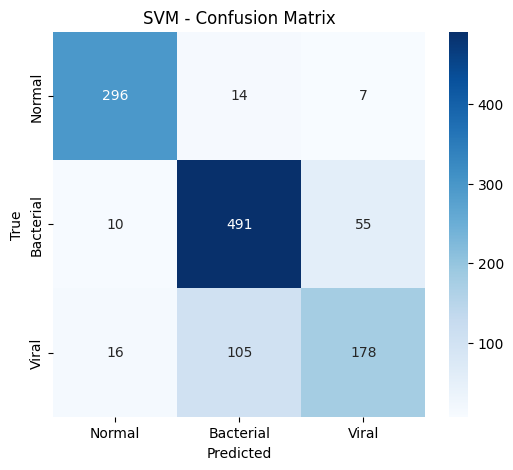

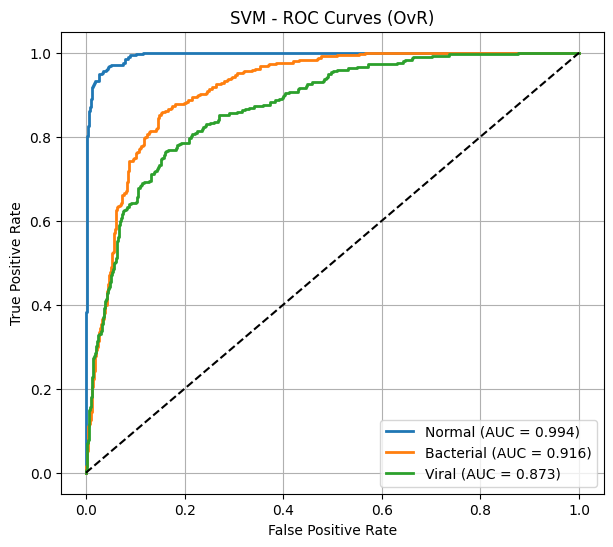

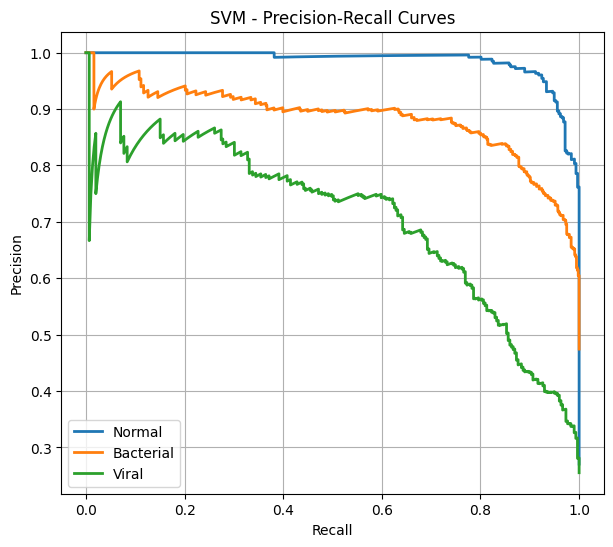

C:\Users\PRECISION\AppData\Local\Temp\ipykernel_15508\2611012071.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette="viridis")


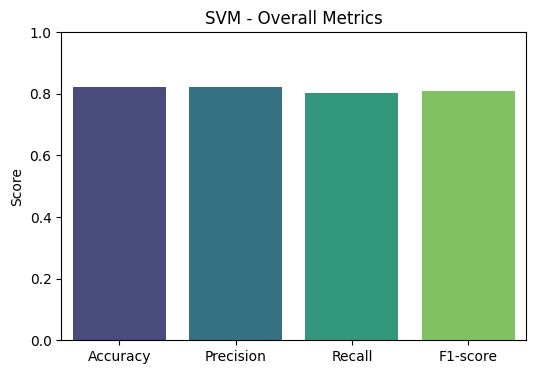


 Training Logistic_Regression 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1561
max_resources_: 4684
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 1561
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 4683
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
2025/11/24 00:25:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Best Params: {'lr__C': 0.1, 'lr__solver': 'lbfgs'}
              precision    recall  f1-score   support

      Normal       0.90      0.91      0.90       317
   Bacterial       0.75      0.80      0.78       556
       Viral       0.58      0.49      0.53       299

    accuracy                           0.75      1172
   macro avg       0.74      0.74      0.74      1172
weighted avg       0.75      0.75      0.75      1172

ROC-AUC (OvR): 0.8729362784456839


2025/11/24 00:25:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



📊 Generating visualizations for Logistic_Regression...


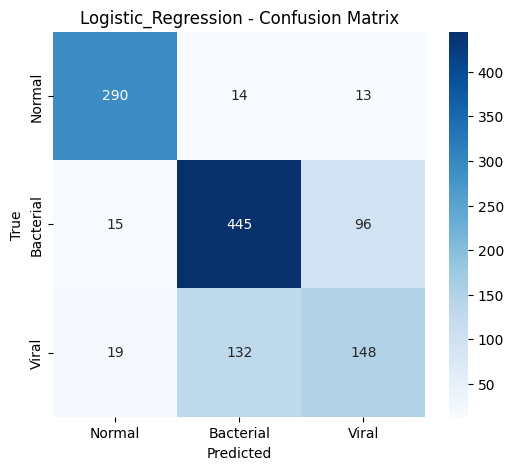

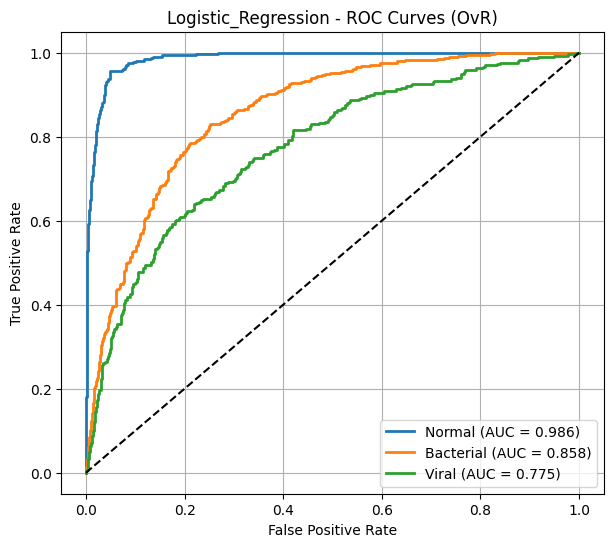

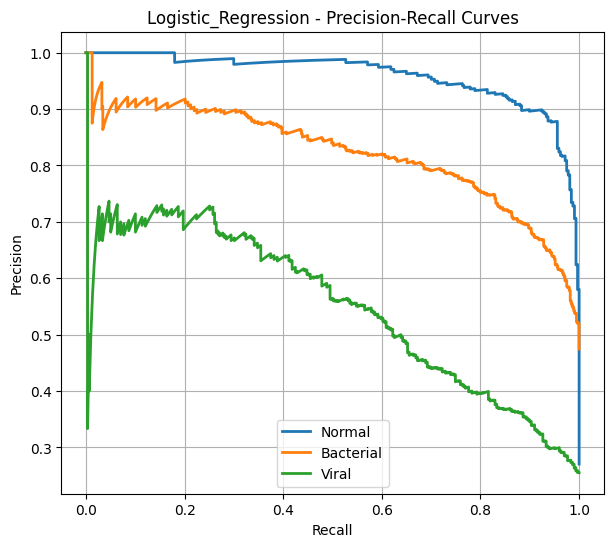

C:\Users\PRECISION\AppData\Local\Temp\ipykernel_15508\2611012071.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette="viridis")


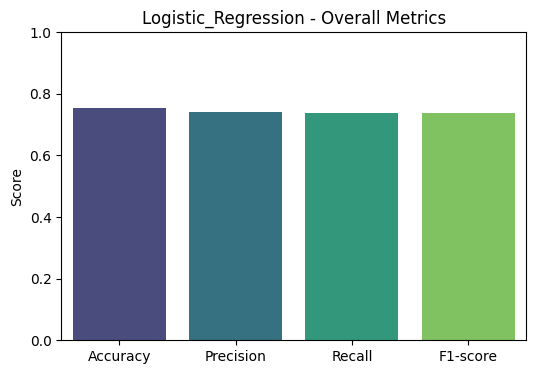


 Training Naive_Bayes 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1561
max_resources_: 4684
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 1561
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 4683
Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025/11/24 00:25:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Best Params: {'nb__var_smoothing': 1e-07}
              precision    recall  f1-score   support

      Normal       0.76      0.86      0.81       317
   Bacterial       0.77      0.68      0.72       556
       Viral       0.51      0.54      0.53       299

    accuracy                           0.69      1172
   macro avg       0.68      0.69      0.68      1172
weighted avg       0.70      0.69      0.69      1172

ROC-AUC (OvR): 0.8370755073314601


2025/11/24 00:25:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



📊 Generating visualizations for Naive_Bayes...


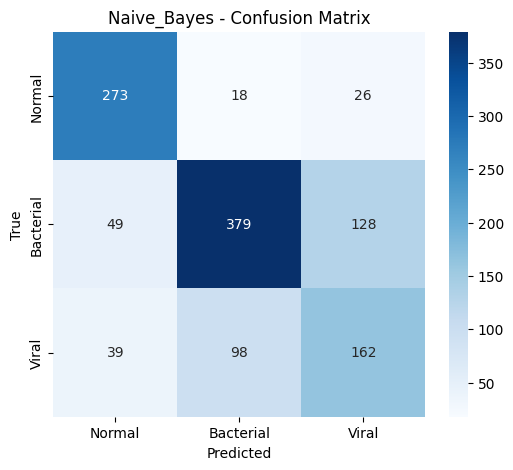

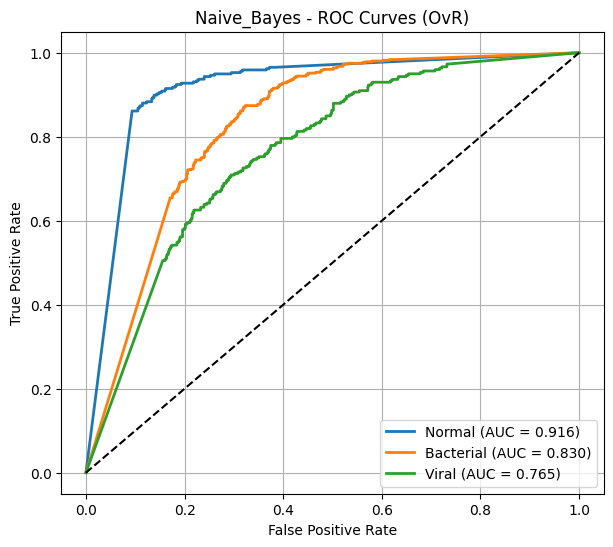

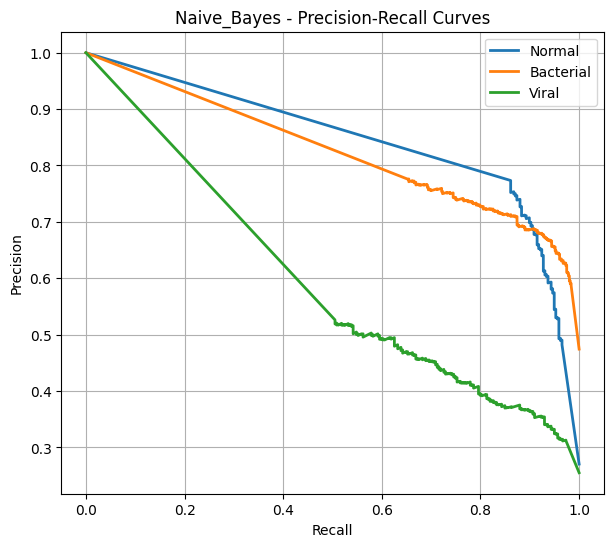

C:\Users\PRECISION\AppData\Local\Temp\ipykernel_15508\2611012071.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette="viridis")


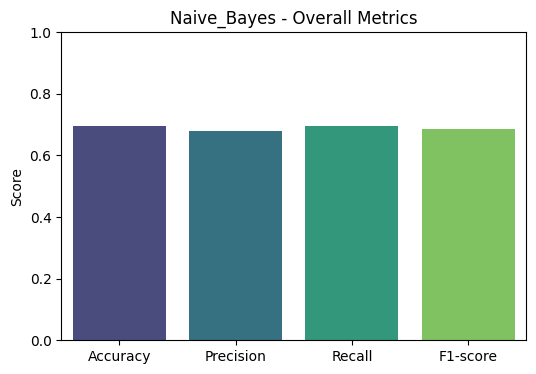



====================== MODEL COMPARISON ======================
                 model  accuracy  precision    recall        f1       auc  \
0                  SVM  0.823379   0.821946  0.804055  0.809708  0.927833   
1  Logistic_Regression  0.753413   0.741299  0.736723  0.737716  0.872936   
2          Naive_Bayes  0.694539   0.678182  0.694886  0.684452  0.837076   

                                            pipeline  
0    (StandardScaler(), SVC(C=10, probability=True))  
1  (StandardScaler(), LogisticRegression(C=0.1, m...  
2  (StandardScaler(), GaussianNB(var_smoothing=1e...  


In [ ]:

# ---------- SVM ----------
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

params_svm = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.001]
}

# ---------- Logistic Regression ----------
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=5000, multi_class="ovr"))
])

params_lr = {
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['lbfgs']
}

# ---------- Naive Bayes ----------
pipe_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

params_nb = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

results = []

results.append(train_and_evaluate_model(
    "SVM",
    pipe_svm, params_svm,
    X_train, y_train,
    X_test, y_test
))

results.append(train_and_evaluate_model(
    "Logistic_Regression",
    pipe_lr, params_lr,
    X_train, y_train,
    X_test, y_test
))

results.append(train_and_evaluate_model(
    "Naive_Bayes",
    pipe_nb, params_nb,
    X_train, y_train,
    X_test, y_test
))

import pandas as pd

df = pd.DataFrame(results)
print("\n\n====================== MODEL COMPARISON ======================")
print(df)


In [1]:
import joblib

model_svm = joblib.load("./svm_model.pkl")
model_lr  = joblib.load("./logreg_model.pkl")
model_nb  = joblib.load("./naivebayes_model.pkl")


In [16]:
import joblib

trained_svm = results[0]['pipeline']
trained_lr  = results[1]['pipeline']
trained_nb  = results[2]['pipeline']

joblib.dump(trained_svm, "svm_model.pkl")
joblib.dump(trained_lr, "logreg_model.pkl")
joblib.dump(trained_nb, "naivebayes_model.pkl")


['naivebayes_model.pkl']

## Testing of Models

In [ ]:
import cv2
import numpy as np

def extract_features_from_path(img_path):
    """
    Loads image → converts to grayscale → extracts all features used during training.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"❌ Could not read image: {img_path}")

    img = cv2.resize(img, (256,256))  
    
    feats = extract_features_from_image(img)  
    return feats.reshape(1, -1)             


In [ ]:
test_images = [
    "chest_xray/NORMAL/IM-0028-0001.jpeg",
    "chest_xray/PNEUMONIA_BACTERIAL/person3_bacteria_13.jpeg",
    "chest_xray/PNEUMONIA_VIRAL/person3_virus_17.jpeg"
]


def predict_single_image(model, img_path):
    features = extract_features_from_path(img_path)
    pred = model.predict(features)[0]

    try:
        probs = model.predict_proba(features)[0]
    except:
        probs = None
        
    return pred, probs

for img in test_images:
    print(f"\n===============================")
    print(f"📌 Testing Image: {img}")

    pred_svm, prob_svm = predict_single_image(model_svm, img)
    pred_lr,  prob_lr  = predict_single_image(model_lr, img)
    pred_nb,  prob_nb  = predict_single_image(model_nb, img)

    print(f"\n🔶 SVM Prediction: {pred_svm}")
    print(f"    Probabilities: {prob_svm}")

    print(f"\n🔶 Logistic Regression Prediction: {pred_lr}")
    print(f"    Probabilities: {prob_lr}")

    print(f"\n🔶 Naive Bayes Prediction: {pred_nb}")
    print(f"    Probabilities: {prob_nb}")



📌 Testing Image: chest_xray/NORMAL/IM-0028-0001.jpeg

🔶 SVM Prediction: 0
    Probabilities: [0.78356495 0.11867931 0.09775574]

🔶 Logistic Regression Prediction: 0
    Probabilities: [7.77769073e-01 2.22230186e-01 7.41370622e-07]

🔶 Naive Bayes Prediction: 1
    Probabilities: [0. 1. 0.]

📌 Testing Image: chest_xray/PNEUMONIA_BACTERIAL/person3_bacteria_13.jpeg

🔶 SVM Prediction: 1
    Probabilities: [0.00576332 0.90185236 0.09238432]

🔶 Logistic Regression Prediction: 1
    Probabilities: [5.77835981e-05 9.98604920e-01 1.33729604e-03]

🔶 Naive Bayes Prediction: 2
    Probabilities: [2.23560401e-208 1.76921303e-112 1.00000000e+000]

📌 Testing Image: chest_xray/PNEUMONIA_VIRAL/person3_virus_17.jpeg

🔶 SVM Prediction: 2
    Probabilities: [0.04004909 0.09460327 0.86534764]

🔶 Logistic Regression Prediction: 2
    Probabilities: [0.00488508 0.01013034 0.98498458]

🔶 Naive Bayes Prediction: 1
    Probabilities: [7.64565609e-75 1.00000000e+00 1.71348268e-46]


## Additional Steps for Explainable AI

In [ ]:
import shap
import numpy as np

def compute_shap_for_model(model, X_train_scaled, X_test_scaled, top_15_idx, feature_names):
    """
    Compute SHAP values for a trained ML model.
    Uses only the selected top features (via MI).
    """

    X_train_shap = X_train_scaled[:, top_15_idx]
    X_test_shap  = X_test_scaled[:, top_15_idx]

    top_15_names = [feature_names[i] for i in top_15_idx]

    background = shap.sample(X_train_shap, 50, random_state=42)

    def model_func(X_small):
        X_full = np.zeros((X_small.shape[0], X_train_scaled.shape[1]))
        X_full[:, top_15_idx] = X_small
        return model.predict_proba(X_full)

    # Explainer
    explainer = shap.KernelExplainer(model_func, background)

    # Compute for 30 samples
    X_subset = X_test_shap[:10]
    shap_values = explainer.shap_values(X_subset)

    return explainer, shap_values, X_subset, top_15_names


In [14]:
def shap_plots(explainer, shap_values, X_subset, top_15_names, instance_idx=4, class_idx=1):
    
    print("\n--- SHAP SUMMARY (Beeswarm) ---")
    shap.summary_plot(shap_values, X_subset, feature_names=top_15_names)

    print("\n--- SHAP WATERFALL ---")
    shap_values_instance = shap_values[class_idx][instance_idx]
    X_instance = X_subset[instance_idx]

    explanation = shap.Explanation(
        values=shap_values_instance,
        base_values=explainer.expected_value[class_idx],
        data=X_instance,
        feature_names=top_15_names
    )

    shap.plots.waterfall(explanation, max_display=10)


100%|██████████| 10/10 [6:54:57<00:00, 2489.72s/it] 
c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:733: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))



--- SHAP SUMMARY (Beeswarm) ---


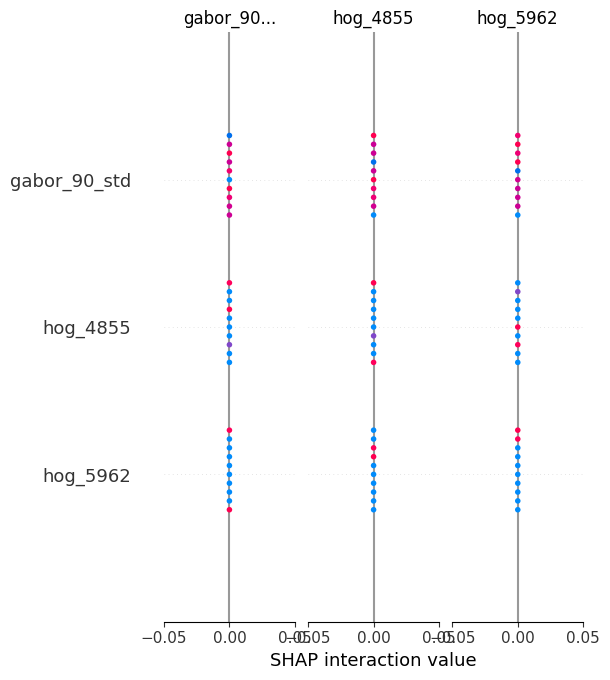


--- SHAP WATERFALL ---


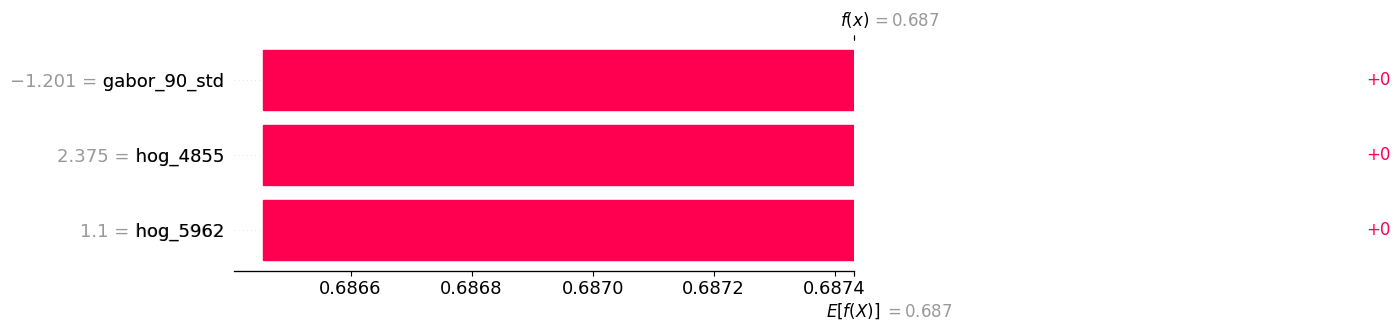

In [15]:
expl_svm, shap_svm, X_svm, names_svm = compute_shap_for_model(
    trained_svm, X_train_scaled, X_test_scaled, top_15_idx, feature_names
)
shap_plots(expl_svm, shap_svm, X_svm, names_svm)


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


--- SHAP SUMMARY (Beeswarm) ---


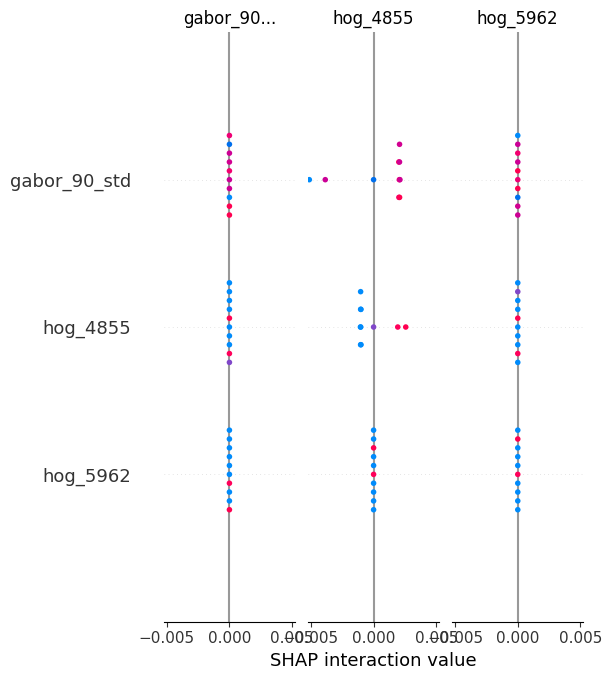


--- SHAP WATERFALL ---


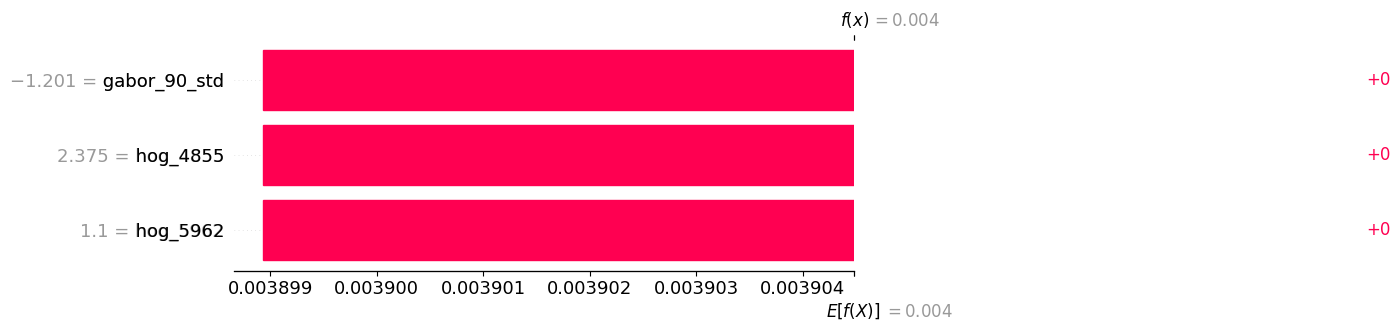

In [16]:
expl_lr, shap_lr, X_lr, names_lr = compute_shap_for_model(
    trained_lr, X_train_scaled, X_test_scaled, top_15_idx, feature_names
)
shap_plots(expl_lr, shap_lr, X_lr, names_lr)


100%|██████████| 10/10 [05:24<00:00, 32.46s/it]



--- SHAP SUMMARY (Beeswarm) ---


c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:733: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
c:\Users\PRECISION\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))


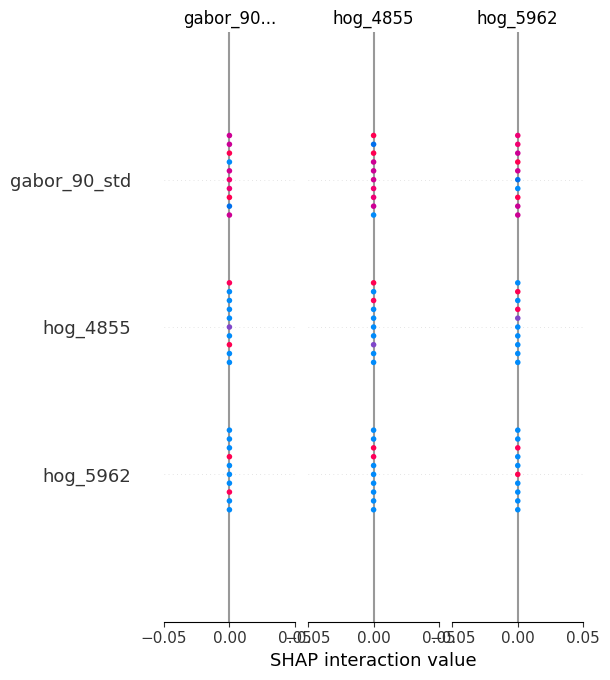


--- SHAP WATERFALL ---


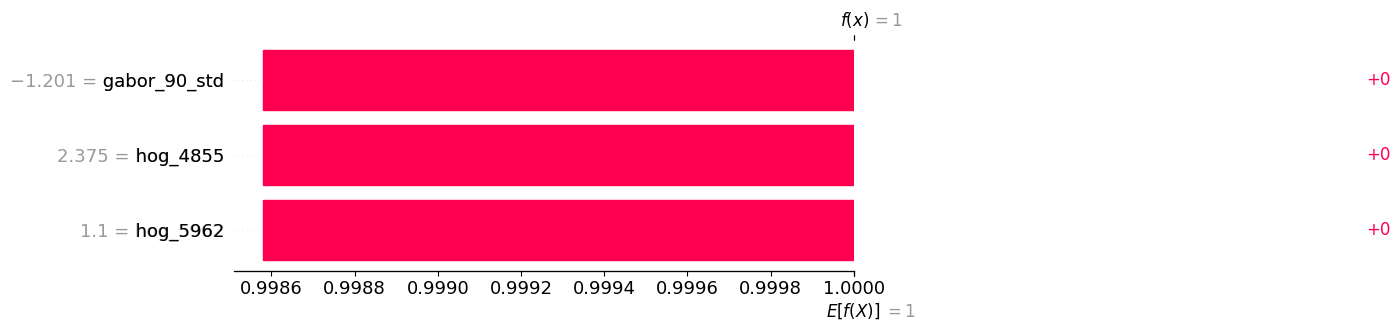

In [17]:
expl_nb, shap_nb, X_nb, names_nb = compute_shap_for_model(
    trained_nb, X_train_scaled, X_test_scaled, top_15_idx, feature_names
)
shap_plots(expl_nb, shap_nb, X_nb, names_nb)